# <span style='font-family: CMU Sans Serif, sans-serif;'> Package import  </span> 

First we import the necessary packages to create simple feed-forward neural networks.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json

from plot_keras_history import show_history, plot_history
from sklearn.model_selection import train_test_split
from keras import layers, models
from keras.callbacks import EarlyStopping
from tensorflow import keras

# <span style='font-family: CMU Sans Serif, sans-serif;'> Data import  </span> 

In [ ]:
# Import primary features
with open("../data__clean/listPrimaryFeaturesRemaining.json", 'r') as f:
    listPrimaryFeatures = json.load(f)

# Import dataframe cleaned for missing values
dataGfdUs = pd.read_csv("../data__clean/usa__gfd__cleaned_v2.csv")

# <span style='font-family: CMU Sans Serif, sans-serif;'> Data preparation  </span>  

Below we create a test/train split for the data.

In [ ]:
X = dataGfdUs[listPrimaryFeatures].reset_index(drop = True)
y = dataGfdUs['ret_exc_lead1m']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# <span style='font-family: CMU Sans Serif, sans-serif;'> Creating a simple feed forward neural networks  </span> 

## <span style='font-family: CMU Sans Serif, sans-serif;'> One hidden layer  </span> 

First we try to create model with one hidden layer and 64 neurons. The activation function will be a ReLU activation. 

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(shape=(len(listPrimaryFeatures),)))  
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(1))

We now define the optimizer and the loss function. We have found the the mean squared error is optimal when we assume data to have Gaussian noise. This is used below. Also we use the ADAM optimizer.

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['MeanAbsoluteError'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,153 (35.75 KB)

 Trainable params: 9,153 (35.75 KB)

 Non-trainable params: 0 (0.00 B)

We are now ready to fit the model. First we use an early stopper

In [ ]:
earlyStop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

We now fit the model:

In [9]:
fitFf1L = model.fit(
    X_train, y_train,
    batch_size = 32,
    epochs=100,
    validation_data = (X_test, y_test),
    callbacks = [earlyStop],
    verbose = True
)

Epoch 1/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 448us/step - MeanAbsoluteError: 0.1005 - loss: 0.0206 - val_MeanAbsoluteError: 0.0870 - val_loss: 0.0156
Epoch 2/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 427us/step - MeanAbsoluteError: 0.0873 - loss: 0.0167 - val_MeanAbsoluteError: 0.0866 - val_loss: 0.0157
Epoch 3/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 444us/step - MeanAbsoluteError: 0.0873 - loss: 0.0166 - val_MeanAbsoluteError: 0.0873 - val_loss: 0.0157
Epoch 4/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 425us/step - MeanAbsoluteError: 0.0872 - loss: 0.0163 - val_MeanAbsoluteError: 0.0871 - val_loss: 0.0156
Epoch 5/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 429us/step - MeanAbsoluteError: 0.0871 - loss: 0.0164 - val_MeanAbsoluteError: 0.0868 - val_loss: 0.0157
Epoch 6/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 438us/step - MeanAbsoluteError: 0.0873 - loss: 0.0162 - val_MeanAbsoluteError: 0.0870 - val_loss: 0.0156
Epoch 7/100
10986/10986 ━━━━━━━━━━━━━━━━━━━━ 5s 439us/step - MeanAbsoluteError: 0.

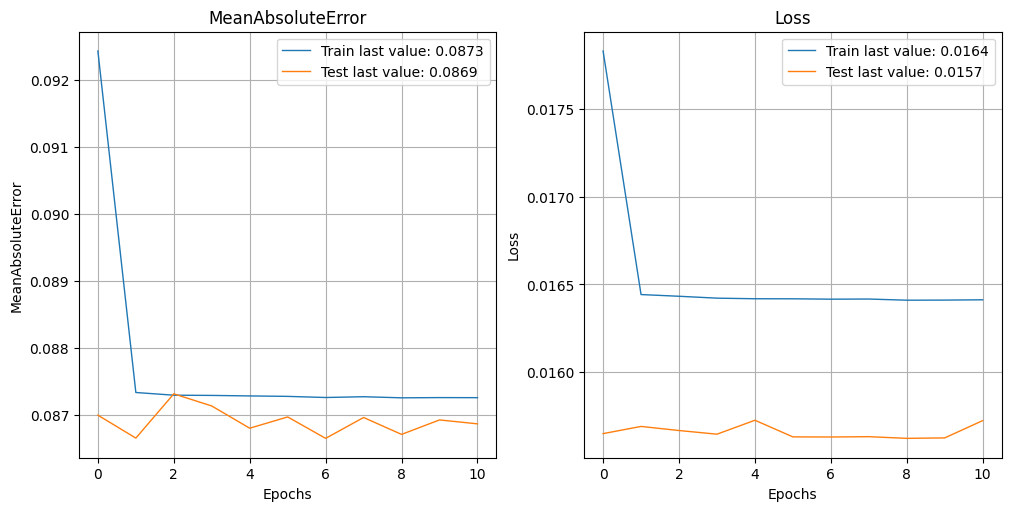

In [10]:
show_history(fitFf1L)

In [ ]:
np.mean(model.predict(X_test) * y_test > 0)

2747/2747 ━━━━━━━━━━━━━━━━━━━━ 1s 199us/step
